In [9]:
import Augmentor
from imgaug import augmenters as iaa
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import random


Small portioin of the dataset

In [19]:
x = np.load("x_train.npy")
y = np.load("y_train.npy")
x.shape, y.shape

((1710, 96, 96, 3), (1710, 2))

# See raw data

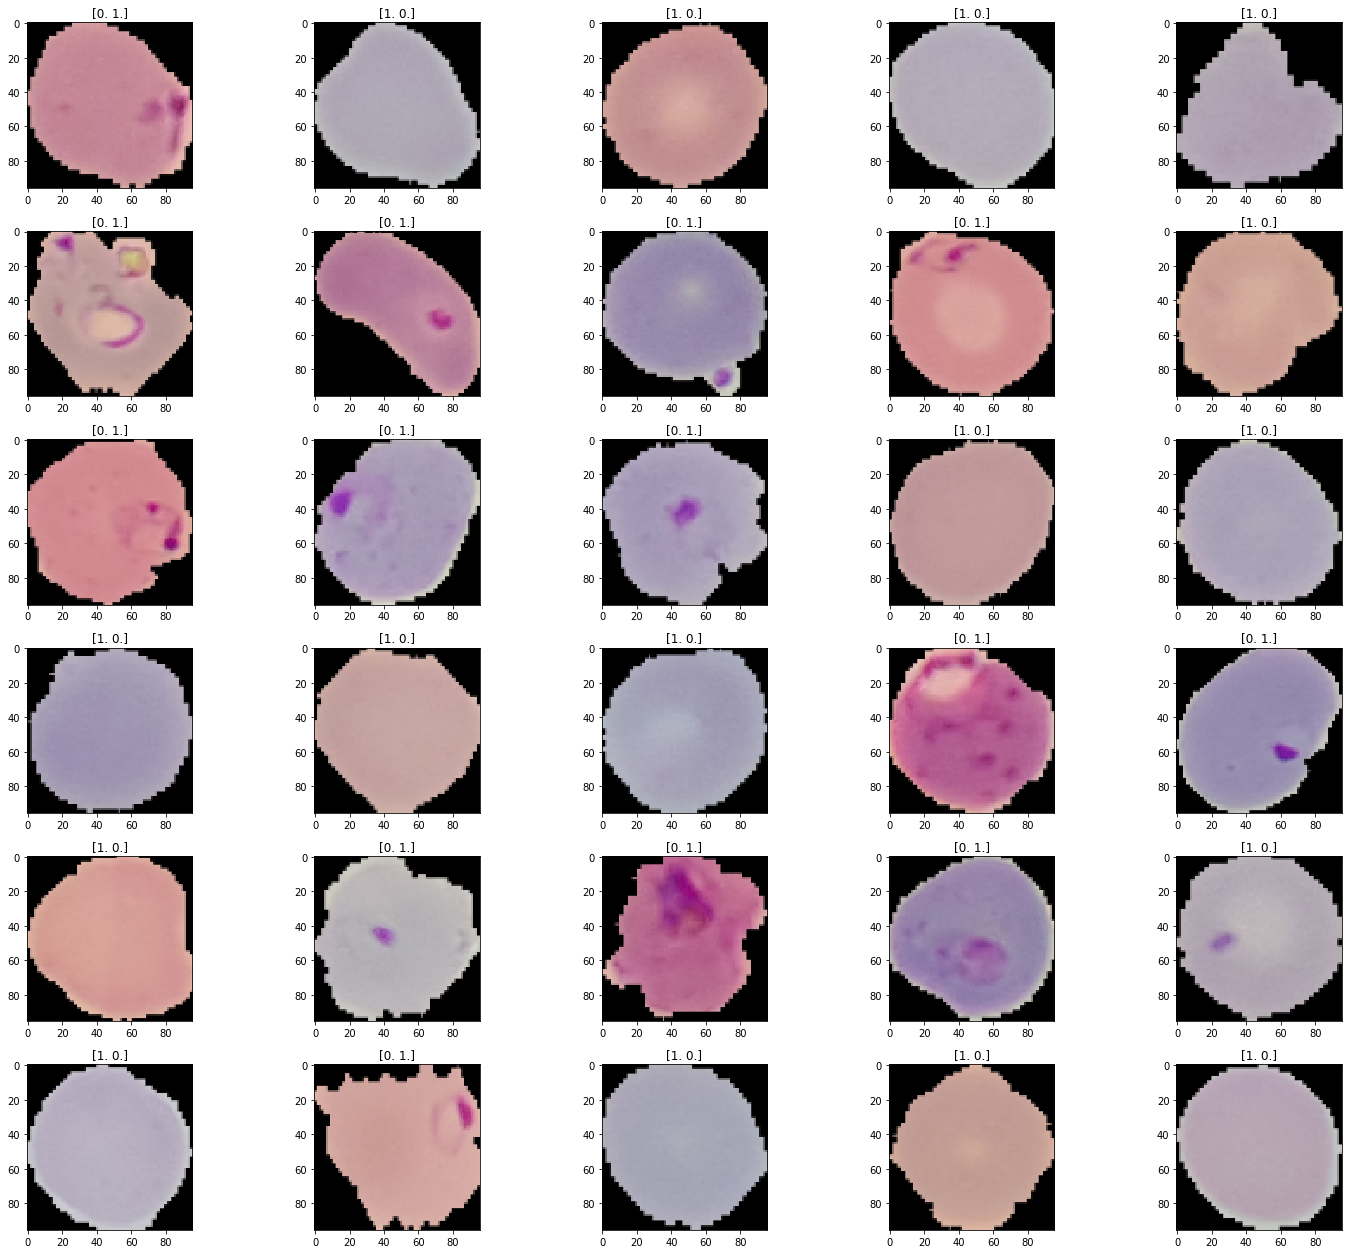

In [37]:
plt.figure(figsize=(20,20))
columns = 5

lower = 0
upper = 30 

for i in range(upper):
    ax = plt.subplot(upper / columns + 1, columns, i + 1)
    idx = random.randint(0, len(x))
    ax.set_title(y[idx])
    plt.imshow(x[idx], cmap='gray') # binary
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Data Augmentation

In [34]:
# standard augment 
seq_standard = iaa.Sequential([
    iaa.Crop(px=(0, 16)), 
    iaa.Fliplr(0.5), 
    iaa.GaussianBlur(sigma=(0, 3.0))
])

# new augment
seq_custom = iaa.Sequential([
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sometimes(0.7, 
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
    ),
    iaa.Affine(
        rotate=(-25, 25),
    ),
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    ),
    iaa.Affine(
        shear=(-25, 25)
    ),
    
    #iaa.Sometimes(0.8, 
     #   iaa.CoarseDropout(0.03, size_percent=0.1)
    #),
], random_order=True) # apply augmenters in random order


def augment_data_minimal( x_values, y_values ):
    counter = 0
    RESIZE_DIM = 96
    X_values_augmented = []
    Y_values_augmented = []
    for x in x_values:
        for p in range(2):
            
            # seq 1
            Y_values_augmented.append( y_values[counter] )
            images_aug = seq_standard.augment_images(x.reshape(1,RESIZE_DIM,RESIZE_DIM,3))   
            X_values_augmented.append( images_aug.reshape(RESIZE_DIM,RESIZE_DIM,3))
            
            # seq 2
            Y_values_augmented.append( y_values[counter] )
            images_aug = seq_custom.augment_images(x.reshape(1,RESIZE_DIM,RESIZE_DIM,3))   
            X_values_augmented.append( images_aug.reshape(RESIZE_DIM,RESIZE_DIM,3))

        counter = counter + 1
    
    
    # prev number of images = n
    # augmented number of images = n * 4 ( 2 seq 2 times)
    X_values_augmented = np.asarray( X_values_augmented )
    Y_values_augmented = np.asarray( Y_values_augmented )
    return (X_values_augmented, Y_values_augmented)

In [30]:
for i in range(2):
    print("Yay!")

Yay!
Yay!


In [35]:
(x_aug, y_aug) = augment_data_minimal( x, y)

x_aug.shape, y_aug.shape

((6840, 96, 96, 3), (6840, 2))

# See augmented images

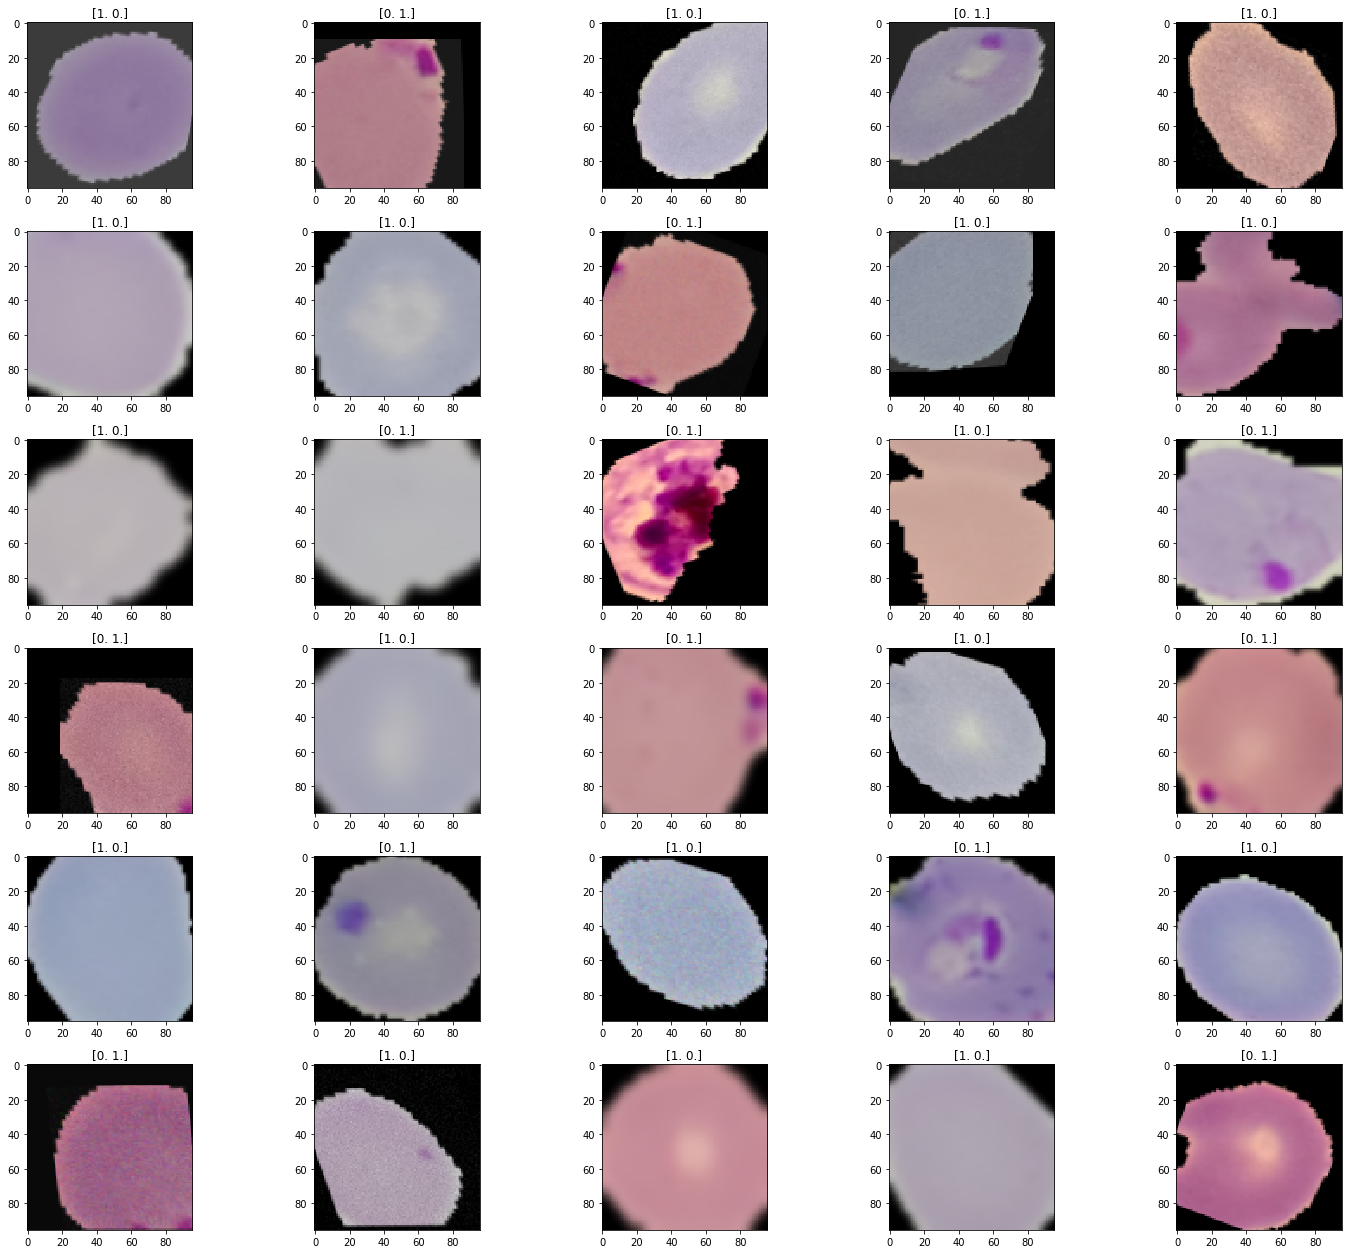

In [36]:
plt.figure(figsize=(20,20))
columns = 5

lower = 0
upper = 30 

for i in range(upper):
    ax = plt.subplot(upper / columns + 1, columns, i + 1)
    idx = random.randint(0, len(x_aug))
    ax.set_title(y_aug[idx])
    plt.imshow(x_aug[idx], cmap='gray') # binary
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Merge all data

In [33]:
X_train_augmented = np.concatenate( (x, x_aug), axis = 0)
Y_train_augmented = np.concatenate( (y, y_aug), axis = 0)

X_train_augmented.shape, Y_train_augmented.shape

((8550, 96, 96, 3), (8550, 2))

## Test of time

In [1]:
def test_of_time(x_test):
    '''
    Arg: x_test: number of test samples of shape (N, w,h,3)
    Returns the predicted labels using test time augmentation    
    '''
    pred_label = []
    label = []
    # number of samples in test set
    l = len(x_test)
    for i in range(l):
        # normal sample
        img = x_test[i]
        # augmented sample reshaped(seq acceptd rank-4 tensor) and fed to sequences
        img_a = seq.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))
        img_b = seq2.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))
        img_c = seq3.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))
        
        # augmented sample reshaped back in normal(rank-3 tensor)
        img_a_out = img_a.reshape(RESIZE_DIM,RESIZE_DIM,3)
        img_b_out = img_b.reshape(RESIZE_DIM,RESIZE_DIM,3)
        img_c_out = img_c.reshape(RESIZE_DIM,RESIZE_DIM,3)
        
        # test of time!
        y_test1 = model.predict(img_a_out[None,:,:,:])
        y_test2 = model.predict(img_b_out[None,:,:,:])
        y_test3 = model.predict(img_c_out[None,:,:,:])
        y_test4 = model.predict(img[None,:,:,:])
        
        # change the params in the weighted average equation for minor changes in the performance
        # future works: arithmetic mean
        
        # coefficients should add up to 1!
        y_test = .2*y_test1 + .2*y_test2 + .2*y_test3 + .4*y_test4
        label.append(y_test)
        
    # convert to final predicted labels
    pred_labels=np.concatenate(label)
    return pred_labels
    

In [2]:
# usage

#label_pred = test_of_time(x_test)
#label_pred.shape

# for tta
#labels=[np.argmax(pred) for pred in label_pred]